<a href="https://colab.research.google.com/github/dohyeon-kim012/MachineLearning-DeepLearning/blob/main/DeepLearning/08.%EC%97%AD%EC%A0%84%ED%8C%8C%20%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 계층 ( Layer )
* 국소적 계산
  * 내가 관심있는 연산만 신경 쓰는 것
  * **계층**별로 국소적 계산이 일어난다!
  * 하나의 계층은 하나의 일만( 국소적 ) 전문적으로 할 수 있어야 한다.
* 예를 들어 ReLU 계층을 만들었으면, ReLU에 대한 순전파(forward), 역전파(backward)만 신경 쓰자...

## 레이어 구현의 주안점
* 순전파와, 역전파를 어떻게 구현해야 할지에 대한 계획을 세워야 한다.
  1. 논문을 보고 하는 경우
    * 논문에 나와있는 순전파, 역전파 수식을 연구
    * 수식을 효율적, 간편하게 짤 수 있는지에 대한 연구 ( 웬만하면 코드 한줄로 마무리 )
    * 조건문, 반복문을 최대한 배제 (단, 레이어 구축에 대한 논문은 제외...)
  2. 스스로 비즈니스를 만들어서 하는 경우
    * 수식을 세우고 컴퓨터로 테스트를 해 봐야 한다.(수식이 컴퓨터에 효율적인지...)
    * Overflow, Underflow 등 컴퓨터에 맞는 수식을 세웠는지 컴퓨터로 검증이 필요하다.

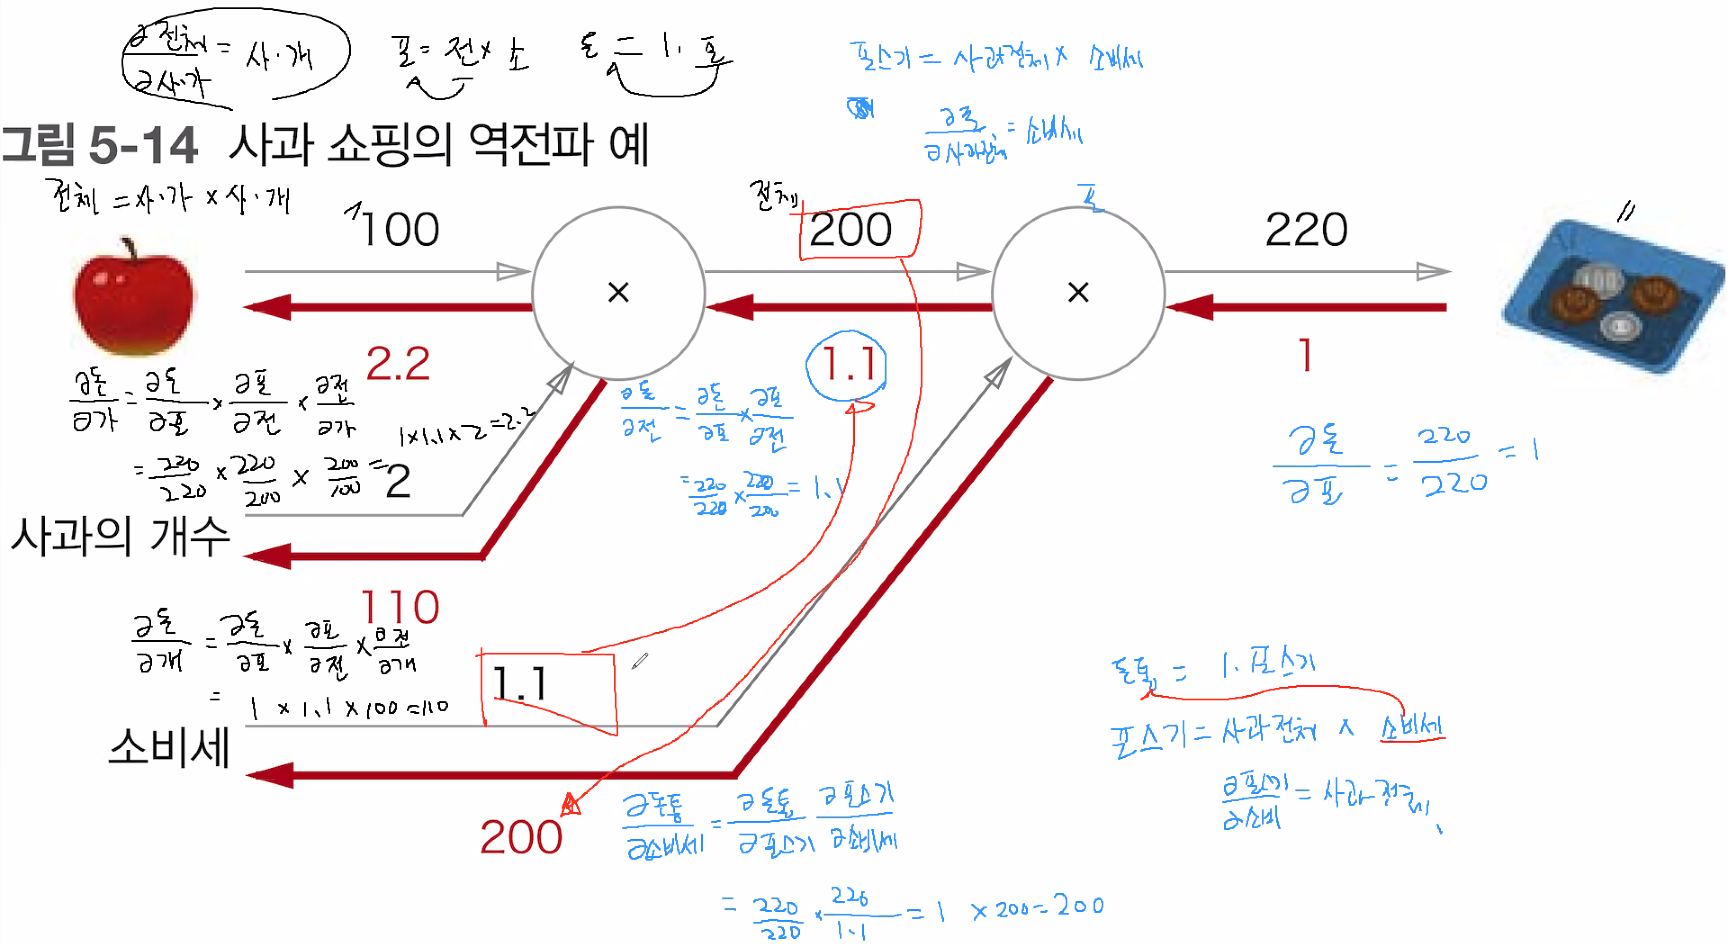

# 덧셈, 곱셈 계층 구현

## 1) 곱셈 계층 구현하기

입력이 `x, y` 일 때  
* `forward` (순전파) : $x * y$
- `backward` (역전파) : $dx = 미분값 * y$ , $dy = 미분값 * x$  
* 비고 : `forward` 시에 입력되었던 `x, y`를 저장하고 있어야 함  
    -> `backward`할 때 반대방향으로 곱해주기 위해서

In [ ]:
class MultiLayer:
    # x, y의 값을 forward에 미리 입력해주어야 함 
    # 딥러닝 레이어 초기화(생성자)는 레이어 전체에서 사용할 옵션이나 변수를 미리 준비하는 역할
    def __init__(self):
        self.x = None
        self.y = None
    
    # 곱셈 레이어에서는 역전파에 필요한 변수(x, y)를 저장
    def forward(self, x, y):
        self.x = x
        self.y = y

        # 순전파 연산
        out = x * y
        return out

    # dout : 다음 층에서 흘러들어오는 미분값
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

1. `__init__` 에서 변수를 만들어만 놓기  
2. `forward`에서 변수를 입력 (저장)
3. `x, y`가 들어 왔기 때문에, `backward`로 나갈 때도 `x, y`가 나가면 됨 -> `dx, dy`

곱셈 레이어 테스트

In [ ]:
# 순전파
apple = 100  # 사과 한개당 가격
apple_cnt = 2  # 사과 개수
tax = 1.1  # 소비세

# 계층은 2개여야 함
# (apple * apple_cnt) * tax

mul_apple_layer = MultiLayer()  # 사과 전체 가격을 구할 레이어
mul_tax_layer = MultiLayer()  # 소비세까지 적용시킨 가격을 구할 레이어

**순전파 수행**

★★★순서가 굉장히 중요★★★ 
 
계획한 순서 그대로 레이어를 배치해서 연산을 해야 한다  
순서가 달라질 경우 역전파를 할 때 문제가 된다  

    순전파 때 A-B-C 순으로 계산을 했다면  
    역전파 때 C-B-A 순으로 역전파 계산이 되어야 한다

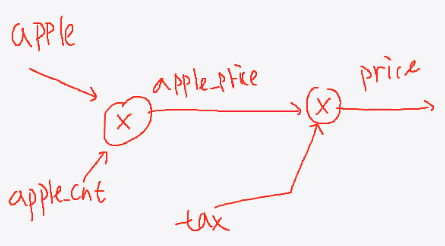

In [ ]:
apple_price = mul_apple_layer.forward(apple, apple_cnt)
price = mul_tax_layer.forward(apple_price, tax)

print("최종 사과의 가격 : {:.0f}".format(price))

최종 사과의 가격 : 220


**역전파 수행**

제일 마지막 값에 대한 미분값을 생각하기

$\frac{\partial돈통}{\partial포스기} = 1$

In [ ]:
dprice = 1

d_apple_price, dtax = mul_tax_layer.backward(dprice)
d_apple, d_apple_cnt = mul_apple_layer.backward(d_apple_price)

print("사과 전체 가격에 대한 미분값 {} = d돈통/d사과전체가격".format(d_apple_price))
print("사과 1개 가격에 대한 미분값 {} = d돈통/d사과1개가격".format(d_apple))
print("사과 개수에 대한 미분값 {:.0f} = d돈통/d사과개수".format(d_apple_cnt))
print("소비세에 대한 미분값 {} = d돈통/d소비세".format(dtax))

사과 전체 가격에 대한 미분값 1.1 = d돈통/d사과전체가격
사과 1개 가격에 대한 미분값 2.2 = d돈통/d사과1개가격
사과 개수에 대한 미분값 110 = d돈통/d사과개수
소비세에 대한 미분값 200 = d돈통/d소비세


## 2) 덧셈 계층 구현하기

- `forward` : `x + y`
- `backward` : 뒷층에서 보낸 미분값에 *1만 하면 된다  

    $\partial x = \partial out * \frac{\partial forward}{\partial x}$ => $dx = dout * 1$  

 $\partial x = \partial out * \frac{\partial forward}{\partial y}$ => $dy = dout * 1$ 

In [ ]:
class AddLayer:
    def __init__(Self):
        # 할 거 없음
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [ ]:
apple = 100  # 사과 1개 가격
apple_cnt = 2  # 사과 개수

orange = 150  # 오렌지 1개 가격
orange_cnt = 3  # 오렌지 개수

tax = 1.1  # 소비세

구해야 하는 항목
1. 전체 가격
2. 사과 개수 (미분값)
3. 사과 전체 가격 (미분값)
4. 사과 1개 가격 (미분값)

5. 오렌지 개수 미분값
6. 오렌지 전체 가격 미분값
7. 오렌지 1개 가격 미분값

8. 소비세 미분값

In [ ]:
mul_apple_layer = MultiLayer()
mul_orange_layer = MultiLayer()
mul_tax_layer = MultiLayer()
add_price_layer = AddLayer()

apple_price = mul_apple_layer.forward(apple, apple_cnt)
orange_price = mul_orange_layer.forward(orange, orange_cnt)
price_before_tax = add_price_layer.forward(apple_price, orange_price)
price_with_tax = mul_tax_layer.forward(price_before_tax, tax)

print('최종 전체 가격 : {:.0f}'.format(price_with_tax))

최종 전체 가격 : 715


In [ ]:
d_price = 1

d_price_before_tax, d_tax = mul_tax_layer.backward(d_price)
d_apple_price, d_orange_price = add_price_layer.backward(d_price_before_tax)
d_apple, d_apple_cnt = mul_apple_layer.backward(d_apple_price)
d_orange, d_orange_cnt = mul_orange_layer.backward(d_orange_price)

print('소비세 미분값 : {}'.format(d_tax))
print('사과 전체 가격 미분값 : {}'.format(d_apple_price))
print('오렌지 전체 가격 미분값 : {}'.format(d_orange_price))
print('사과 1개 가격 미분값 : {}'.format(d_apple))
print('오렌지 1개 가격 미분값 : {:.0f}'.format(d_orange))
print('사과 개수 미분값 : {:.0f}'.format(d_apple_cnt))
print('오렌지 개수 미분값 : {}'.format(d_orange_cnt))

소비세 미분값 : 650
사과 전체 가격 미분값 : 1.1
오렌지 전체 가격 미분값 : 1.1
사과 1개 가격 미분값 : 2.2
오렌지 1개 가격 미분값 : 3
사과 개수 미분값 : 110
오렌지 개수 미분값 : 165.0


# 신경망 레이어 구현

## ReLU 레이어
* `forward` : 입력값이 0보다 작으면 0으로, 0보다 크면 입력값을 그대로 출력
* `backward` : `forward`시에 0보다 작았으면 해당 위치의 값을 0으로 설정, 0보다 컸으면 변화율이 1이기 때문에 미분값을 그대로 유지

- `mask` : $\frac{\partial y}{\partial x}$
    - x에 대한 y의 미분값
    - 순전파 시에 음수였던 인덱스를 저장해서 역전파에서 0으로 만들기 위함
    - 순전파에서 구해놓고 역전파에서 곱해줌 :  
$dout$ (다음 층에서 흘러 들어오는 값)에 곱해줌  

* 비고 : 어떤 인덱스의 값이 음수였는지를 저장. `forward`할 때 알 수 있음!

In [ ]:
class ReLU:
    def __init__(self):

        # mask : 순전파 시에 음수였던 인덱스를 저장하기 위함
        # mask 가 있어야 순전파 때의 음수였던 수를 역전파에서 0으로 만들 수 있음
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)  # 음수: True, 양수: False

        out = x.copy()  # 원본 배열 복사
        out[self.mask] = 0  # numpy 배열의 음수였던 부분(True)만 인덱싱하여 0으로 만듦
        
        return out

    def backward(self, dout):
        # 순전파 때 음수였던 부분을 0으로 만들었음
        # 음수였던 인덱스를 기억하고 있다가(self.mask), 미분값 전달 시 해당 인덱스 0으로 만듦
        dout[self.mask] = 0
        dx = dout

        return dx

In [ ]:
import numpy as np

x = np.array([[-0.9, -1.1],
              [3.5, -9.6]])

relu = ReLU()
relu.forward(x)

array([[0. , 0. ],
       [3.5, 0. ]])

In [ ]:
relu.mask  # 양수: False, 음수: True

array([[ True,  True],
       [False,  True]])

In [ ]:
dout = np.array([[-0.4, -2.1],
                 [-3.3, 1.8]])

relu.backward(dout)

array([[ 0. ,  0. ],
       [-3.3,  0. ]])

## $\sigma$ 시그모이드 구현
$$
\sigma(x) = \frac{\mathrm{1} }{\mathrm{1} + exp(-x)}
$$

$$
y = \sigma(x)
$$

$$
y' = \sigma(x)(1-\sigma(x))
$$

$$
y' = y(1-y)
$$

* 시그모이드 레이어에서 순전파 때 기억하고 있어야 할 값 : $y$값만 알고 있으면 된다.

In [ ]:
class Sigmoid:

    def __init__(self):
        # y를 out이라고 한다면
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx

## Affine 계층 구현

어파인 변환 affine transformation : 신경망의 순전파 때 수행하는 행렬의 곱 = `Dense` Layer 

- `forward`  
    1. 입력값 `X`와 가중치 `W`의 내적 + `b` (`WX+b`)  
    2. 평탄화  
        - 1차원 배열로 데이터가 들어왔을 때 대응  
        - 다차원 배열(tensor)에 대한 대응 (ex.이미지데이터)  
        - forward에서 **원본 데이터의 형상을 저장**해야 backward에서 다시 복구시킬 수 있음

- `backward`  1. $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T$ 2. $\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}$ 3. $\frac{\partial B}{\partial L} = \frac{\partial L}{\partial Y}$

    1. 미분값(`dout`)과 가중치의 전치행렬(`W.T`) 내적 ( 입력값에 대한 미분값 )  
    2. 입력값의 전치행렬(`X.T`)와 미분값(`dout`) 내적 ( 가중치에 대한 미분값 )  
    3. 배치를 축으로 편향의 합 구하기 (`axis = 0`)   
    4. 입력값의 미분값(`dx`)의 형상을 원본 `x`의 형상으로 다시 바꿔주기  
        -> 언패킹에 `*` 사용  
    5. dx 값만 return 받음 (↓ 아래 그림에서 이유가 설명됨)  

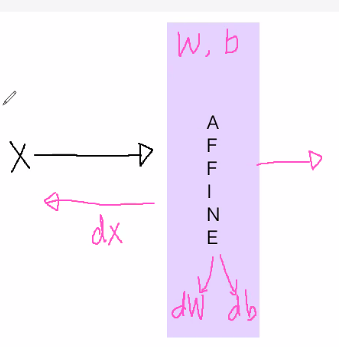

In [ ]:
class Affine:
    def __init__(self, W, b):
        '1. 가중치, 편향, 입력값 x -> 가중치, 편향은 생성자에서 저장'
        self.W = W
        self.b = b

        self.x = None

        '''2. x의 형상
        x에 대한 역전파를 수행하면서 형상이 바뀐 x의 미분값의 형상을 
        원래 형상으로 돌리기 위해 원본 x의 형상을 저장할 변수 생성해두기'''
        self.original_x_shape = None

        '''3. W와 b의 기울기 배열
        최적화(Optimization)을 위해 각 매개변수의 미분값을 가지고 있어야 함
        추후 경사하강법 등을 구현하기 위해 사용
        dW, db를 사용해서 W와 b를 갱신(update)하는 것을 <<학습>>이라고 함'''
        self.dW = None
        self.db = None

    def forward(self, x):
        '''텐서 대응을 위해 입력값 x의 형상을 저장
        ex ) (3, 2, 3) - 3개의 데이터가 (2, 2) 모양으로 들어있는 형태
        (N, x1, x2) -> (3, 4)로 평탄화 -> 역전파에서 (3, 2, 2)로 다시 reshape'''
        self.original_x_shape = x.shape

        # 평탄화 진행
        DATA_SIZE = x.shape[0] # 배치 사이즈 가져오기
        x = x.reshape(DATA_SIZE, -1)

        self.x = x # 역전파 때 가중치에 곱하기 위해 저장.

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)

        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape) # (12, 3) -> *(12, 3) -> 12, 3으로 언패킹 된다.

        return dx

## Softmax_with_Loss 계층 ( 출력층 ) 구현  

데이터가 앞서 만들어놓은 Affine 계층과 ReLU 계층을 지나며 변환되고,  
출력층인 Softmax_with_Loss 계층을 통해 출력됨

softmax 에 의한 분류 및 CEE 를 활용한 손실함수를 동시에 구현  

- `forward`
    - softmax 와 loss 를 적용
        - 정답 레이블(`t`)
        - 예측값 ( 소프트맥스 결과물 )
        - loss값 ( 기록 및 확인용 )
- `backward`
    - 순수한 오차 (`y-t`)를 구해서 이전 층에 전달함
    - **주의사항** : t가 원핫인코딩이 되어 있는지, 안 되어 있는지에 따라 코드 달라짐

    ```python
    ex)
    y : 5개의 배치 데이터에 대한 소프트맥스의 결과물

    y = [[0.0, 0.1, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.1, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.1, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.1, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.1, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0]]
     
    첫 번째 행의 '1 (y) - 0.7 (t)'을 구하면 '0.3'이 순수한 오차가 됨  
     ```

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [ ]:
class SoftmaxWithLoss:

  def __init__(self):
    self.loss = None # 손실값 (시각화 할 때 사용할 예정..)
    self.y    = None # 예측값 ( 역전파 때 사용 )
    self.t    = None # 정답 레이블 ( 역전파 때 사용 )

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1): # dout이 1인 이유 : d돈통 / d포스기 개념
    # 배치 고려하기
    batch_size = self.t.shape[0]

    '''t가 원-핫 인코딩이 되어있는지, 안 되어있는지 고려해야 함
    출력층의 원소 개수를 비교하는 것은 원-핫 인코딩이 되어있는 t임
    y는 항상 softmax의 결과물 (N, OUTPUT_SIZE)
    t가 원핫인코딩이 되어 있으면 (N, OUTPUT_SIZE)
    t가 원핫인코딩이 안 되어 있으면 1차원 배열로 들어가므로 (N, )'''
    
    # t가 원-핫인코딩 되어 있는 경우
    if self.t.size == self.y.size:
        dx = (self.y - self.t) / batch_size
    # t가 원-핫인코딩 안되어 있는 경우
    else: 
        dx = self.y.copy()
        '''원핫인코딩이 되어있지 않은 t는 정답 레이블의 인덱스로 생각할 수 있다
        y = [0.2, 0.1, 0.7], t = 2
        dx[np.arange(batch_size), self.t] -> dx[0, 2] -> 0.7 -> 0.7 - 1 을 구하겠다는 의미
        --> -0.3 만큼의 오차가 있다'''
        dx[np.arange(batch_size), self.t] -= 1
        dx = dx / batch_size

    return dx

# 신경망 레이어를 이용해서 MNIST 분류 네트워크 구축

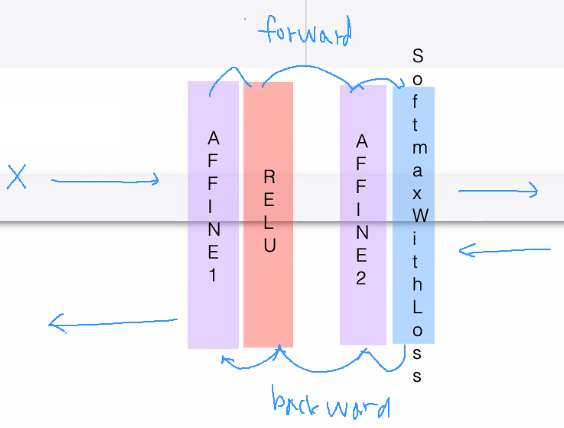

역전파 할 때 순전파와 그대로의 순서대로 레이어를 지나와야 함  
-> 즉, **순서**가 중요함  
-> 추가 순서가 유지되는 dict를 써야 함 : `OrderedDict`

In [ ]:
from collections import OrderedDict 

**코드를 짜기 전 계획을 먼저 세울 것!!**

1. 생성자에서 만들어준 레이어들을 먼저 확인해보기
    - `predict` : `Affine1` + `ReLU` + `Affine2` 
    - `predict`의 각 레이어에서 forward 함수를 호출하여 x값을 넘겨야함
    - 만들어둔 dict `self.layers`에는 {"Affine" : Affine(W1, b1)} 의 형식으로 값이 들어가 있음  
     -> .values 를 통해 리스트로 만들면 value인 각 클래스의 객체로만 이루어진 리스트가 생성됨
    ```python
    for layer in self.layers.values():
    x = layer.forward(x)

    return x
    ```

2. `loss` 확인
    - `self.lastLayer` 의 forward 함수를 호출해야 함
    - y값이 필요하니 변수를 생성
    ```python
    y = self.predict(x)

    return self.lastLayer.forward(y, t)
    ```

3. 역전파
    - 역전파를 하기 위해서는 오차(순전파 결과값)을 먼저 구해야 함 -> loss 함수의 결과값
    - 미분을 위해 dout 값을 구해야 함 -> 출력층인 lastLayer에서 구함
    - Layer들을 거꾸로 뒤집어서 각 레이어의 backward 함수에 미분값 통과시키면 됨
    ```python
    self.loss(x, t)
    
    dout = self.lastLayer.backward(dout)  -> 순수한 오차 y - t 구할 수 있음

    layers = list(self.layers.values())
    layers.reverse()

    for layer in layers:
    dout = layer.backward(dout)
    ```

In [ ]:
class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 매개변수 초기화
    self.params = {}

    # 1층 은닉층을 위한 매개변수
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)

    # 2층 출력층을 위한 매개변수
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

    # 레이어 만들기
    # 추가되는 레이어의 순서가 바뀌면 안되기 때문에 OrderedDict를 활용
    self.layers = OrderedDict()

    # Affine 1층 (은닉층 - Fully Connected Layer)
    self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
    self.layers["ReLU"] = ReLU()

    # Affine 2층 (출력층)
    self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])

    # 항상 마지막 층은 SoftmaxWithLoss가 되어야 한다.
    self.lastLayer = SoftmaxWithLoss()
  
  def predict(self, x):
    # 순전파
    # self.layers에 들어있는 모든 레이어를 순서대로 꺼내서 forward 시키면 된다.

    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  # loss 별도 구현 (softmaxwithloss 포함)
  def loss(self, x, t):
    # predict를 하고, predict에 대한 loss를 구하면 된다.
    y = self.predict(x)

    return self.lastLayer.forward(y, t)
  
  def accuracy(self, x, t):
    # 예측을 하고, 정답이랑 얼마나 틀렸는지를 계산
    # 단, t가 원-핫 인코딩이 되어있는지, 안되어있는지가 중요!
    y = self.predict(x)
    y = np.argmax(y, axis=1) # 제일 큰 값 하나만 뽑자.( 제일 확률이 높은 곳에 위치한 인덱스를 갖는다. )

    # 원-핫 인코딩 처리
    # t.ndim != 1 --> t가 원핫 인코딩이 되어있는 상태라면
    # t에서 제일 높은 인덱스를 찾겠다.
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])

    return accuracy
  
  # 역전파를 활용한 기울기 배열 구하기
  def gradient(self, x, t):
    # 역전파를 하기 위해 필요한 것
    #  1. 오차를 먼저 구해야 한다.
    #   오차를 구하려면? 예측(predict)을 해서 loss를 계산해야 오차를 구할 수 있다.
    self.loss(x, t)

    # 역전파
    dout = 1 # dL/dL --> d돈통 / d포스기

    # SoftmaxWithLoss의 오차에 대한 미분값을 구해오자
    dout = self.lastLayer.backward(dout) # 순수한 오차가 나온다 (y - t)

    layers = list(self.layers.values()) # 레이어를 모두 가지고 와서
    layers.reverse() # 순서 뒤집기

    # 순서가 뒤집어진 레이어를 하나씩 꺼내서
    for layer in layers:
      # 미분값을 집어 넣으면서 역전파!
      dout = layer.backward(dout)
    
    # 구해진 미분값(기울기)을 저장
    grads = {}
    grads["W1"], grads["b1"] = self.layers["Affine1"].dW, self.layers["Affine1"].db
    grads["W2"], grads["b2"] = self.layers["Affine2"].dW, self.layers["Affine2"].db

    return grads

  # 구식 방법. 수치미분을 활용해서 기울기 구하기( 사용하지 않습니다. 왜? 느리니까..)
  def numerical_gradient_params(self, x, t):
      loss_W = lambda W: self.loss(x, t)
          
      grads = {}
      grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
      grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
      grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
      grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
          
      return grads

**list와 dict 정리**

`dict.values()` -> dict의 value들을 list로서 정리하고 for 문을 돌릴 수 있음  
그러나, 온전한 list로 형이 바뀌는 건 아니기 때문에 list용 함수를 쓸 수는 없음  

따라서, list용 함수인 reverse를 쓰기 위해서는 아예 형변환을 하여 별도의 변수로 저장해야함  
`list = list(dict.values())`  
`list.reverse()`

수치 미분과 오차역전파를 했을 때의 기울기 비교

In [ ]:
from tensorflow.keras import datasets
from sklearn.preprocessing import OneHotEncoder

mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train_dummy = OneHotEncoder().fit_transform(y_train.reshape(-1, 1))
y_train_dummy = y_train_dummy.toarray()

y_test_dummy = OneHotEncoder().fit_transform(y_test.reshape(-1, 1))
y_test_dummy = y_test_dummy.toarray()

# feature 전처리
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train / 255.0 # 이미지 정규화 기법. 255.0 으로 나눠주면 모든 픽셀 데이터가 0 ~ 1사이의 값을 갖게 되고, 훈련이 쉽게 된다.

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test / 255.0

## MNIST로 최종 테스트하기

In [ ]:
network = TwoLayerNet(input_size=28*28, hidden_size=50, output_size=10)

# 하이퍼 파라미터 설정
iter_num = 10000 # 학습 반복 횟수
learning_rate = 0.1 # 학습률
batch_size = 100 # 배치 사이즈
train_size = X_train.shape[0] # 훈련할 이미지의 개수

# 훈련 과정을 1 에폭마다 기록 (시각화)
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 에폭 횟수 구하기
# BATCH를 이용해서 전체 데이터를 모두 사용하면 1에폭
#  100개의 배치를 이용해서 600번의 훈련을 반복하면 총 60000개(전체 데이터의 개수)의 데이터로 훈련하는 것
#  이 때가 1 에폭이다.

iter_per_epoch = int(max(train_size / batch_size, 1)) # max를 쓴 이유 : 종종 train_size < batch_size 일 때는 한번만 학습

for i in range(iter_num):
  # 미니 배치 생성
  batch_mask = np.random.choice(train_size, batch_size)
  X_batch = X_train[batch_mask]
  t_batch = y_train[batch_mask]

  # 훈련 1단계 - 기울기 계산
  grads = network.gradient(X_batch, t_batch)

  # 훈련 2단계 - 경사하강법 수행(최적화 - Optimization)
  for key in ["W1", "b1", "W2", "b2"]:
    # params에는 실제 가중치, 편향이 들어있음
    # grads에는 dL/W1, dL/b1, dL/W2, dL/b2 ( 기울기(미분값)가 들어있음)
    network.params[key] -= learning_rate * grads[key] # 매개변수 갱신
  
  # 1에폭 마다 정확도, loss 확인
  if i % iter_per_epoch == 0:
    loss = network.loss(X_batch, t_batch)
    train_acc = network.accuracy(X_train, y_train)
    test_acc  = network.accuracy(X_test, y_test)

    train_loss_list.append(loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("Train Accuracy : {:.6f} / Test Accuracy : {:.6f} / Train Loss : {:.6f}".format(train_acc, test_acc, loss))

Train Accuracy : 0.092783 / Test Accuracy : 0.097700 / Train Loss : 2.301312
Train Accuracy : 0.904783 / Test Accuracy : 0.905700 / Train Loss : 0.218490
Train Accuracy : 0.921883 / Test Accuracy : 0.923200 / Train Loss : 0.149130
Train Accuracy : 0.938283 / Test Accuracy : 0.936600 / Train Loss : 0.285031
Train Accuracy : 0.947983 / Test Accuracy : 0.945500 / Train Loss : 0.171715
Train Accuracy : 0.954383 / Test Accuracy : 0.951400 / Train Loss : 0.193849
Train Accuracy : 0.958450 / Test Accuracy : 0.953600 / Train Loss : 0.099076
Train Accuracy : 0.960767 / Test Accuracy : 0.957400 / Train Loss : 0.077232
Train Accuracy : 0.965633 / Test Accuracy : 0.959300 / Train Loss : 0.071477
Train Accuracy : 0.969117 / Test Accuracy : 0.963900 / Train Loss : 0.125319
Train Accuracy : 0.971183 / Test Accuracy : 0.964300 / Train Loss : 0.038513
Train Accuracy : 0.971767 / Test Accuracy : 0.965800 / Train Loss : 0.066900
Train Accuracy : 0.974583 / Test Accuracy : 0.968100 / Train Loss : 0.031046

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

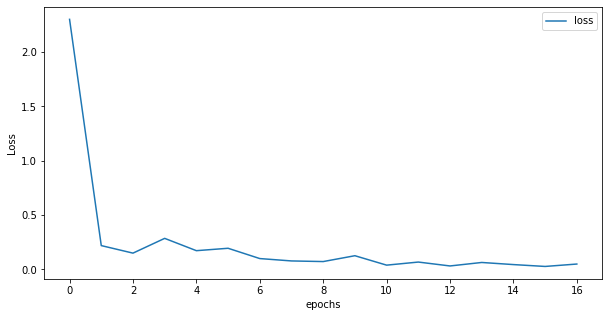

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

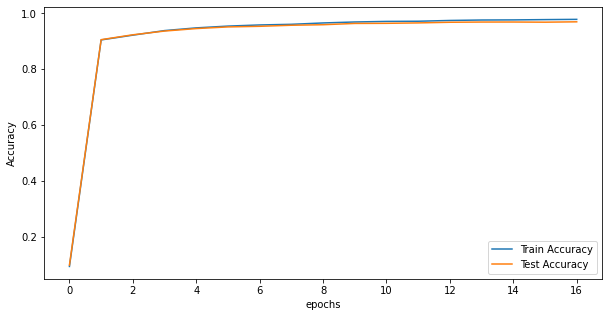

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label="Train Accuracy")
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label="Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()